# Demonstração - Economiza+ MVP

**Sprint 2 - Dia 13**  
**Objetivo:** Demonstrar o fluxo completo do sistema para usuários de cada cluster

**Demonstrações:**
1. Fluxo completo para 1 usuário de cada cluster (4 usuários)
2. Visualizações detalhadas de perfil
3. Recomendações personalizadas
4. Alertas de anomalias
5. Validação de reproducibilidade

**Público-alvo:** Apresentação para stakeholders e validação do MVP

---
## 1. Setup e Carregamento do Pipeline

In [1]:
import pandas as pd
import numpy as np
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("="*70)
print("       ECONOMIZA+ MVP - DEMONSTRAÇÃO DO SISTEMA")
print("="*70)
print(f"\nData: {datetime.now().strftime('%d/%m/%Y %H:%M')}")
print("\nSistema de análise financeira e recomendações personalizadas")
print("para famílias brasileiras das classes C e D")

       ECONOMIZA+ MVP - DEMONSTRAÇÃO DO SISTEMA

Data: 29/01/2026 20:20

Sistema de análise financeira e recomendações personalizadas
para famílias brasileiras das classes C e D


In [2]:
# Carregar pipeline completo
print("\nCarregando componentes do sistema...")

pipeline_data = joblib.load('../models/pipeline_completo.pkl')

# Extrair componentes
kmeans_model = pipeline_data['componentes']['kmeans']
scaler_clustering = pipeline_data['componentes']['scaler_clustering']
isolation_forest = pipeline_data['componentes']['isolation_forest']
scaler_anomalias = pipeline_data['componentes']['scaler_anomalias']
regras_recomendacao = pipeline_data['regras_recomendacao']
stats_categoria = pd.DataFrame(pipeline_data['stats_categoria'])

# Configurações - converter chaves para inteiros
CLUSTER_NAMES = {int(k): v for k, v in pipeline_data['configuracoes']['cluster_names'].items()}
CLUSTER_PRIORIDADES = {int(k): v for k, v in pipeline_data['configuracoes']['cluster_prioridades'].items()}
FEATURES_CLUSTERING = pipeline_data['configuracoes']['features_clustering']

# Carregar dados
usuarios = pd.read_csv('../data/raw/usuarios.csv')
transacoes = pd.read_csv('../data/raw/transacoes.csv')
usuarios_clustered = pd.read_csv('../data/processed/usuarios_clustered.csv')

print("[OK] Pipeline carregado com sucesso!")
print(f"\nComponentes disponíveis:")
print(f"  - Modelo de clustering (K-means, 4 perfis)")
print(f"  - Sistema de recomendações (8 regras)")
print(f"  - Detector de anomalias (Isolation Forest)")
print(f"\nDados carregados:")
print(f"  - {len(usuarios)} usuários")
print(f"  - {len(transacoes)} transações")


Carregando componentes do sistema...
[OK] Pipeline carregado com sucesso!

Componentes disponíveis:
  - Modelo de clustering (K-means, 4 perfis)
  - Sistema de recomendações (8 regras)
  - Detector de anomalias (Isolation Forest)

Dados carregados:
  - 500 usuários
  - 194231 transações


---
## 2. Classe do Pipeline (Reprodução)

In [3]:
class EconomizaPipeline:
    """Pipeline integrado do Economiza+ MVP."""
    
    def __init__(self, kmeans_model, scaler_clustering, regras_recomendacao,
                 isolation_forest, scaler_anomalias, stats_categoria):
        self.kmeans = kmeans_model
        self.scaler_clustering = scaler_clustering
        self.regras = regras_recomendacao
        self.isolation_forest = isolation_forest
        self.scaler_anomalias = scaler_anomalias
        self.stats_categoria = stats_categoria
        self.cluster_names = CLUSTER_NAMES
        self.cluster_prioridades = CLUSTER_PRIORIDADES
        self.features_clustering = FEATURES_CLUSTERING
        
    def calcular_features_usuario(self, transacoes_usuario):
        renda = transacoes_usuario[transacoes_usuario['categoria'] == 'Renda']['valor']
        gastos = transacoes_usuario[transacoes_usuario['categoria'] != 'Renda']
        n_meses = transacoes_usuario['mes'].nunique()
        
        media_renda = renda.sum() / n_meses if len(renda) > 0 and n_meses > 0 else 0
        media_gasto = gastos['valor'].sum() / n_meses if len(gastos) > 0 and n_meses > 0 else 0
        taxa_poupanca = (media_renda - media_gasto) / media_renda if media_renda > 0 else 0
        
        gastos_essenciais = gastos[gastos['is_essencial'] == True]['valor'].sum()
        pct_gastos_essenciais = gastos_essenciais / gastos['valor'].sum() if gastos['valor'].sum() > 0 else 0
        
        gastos_mensais = gastos.groupby('mes')['valor'].sum()
        std_gasto = gastos_mensais.std() if len(gastos_mensais) > 1 else 0
        
        return {
            'media_renda': media_renda,
            'media_gasto': media_gasto,
            'taxa_poupanca': taxa_poupanca,
            'pct_gastos_essenciais': pct_gastos_essenciais,
            'std_gasto': std_gasto if not pd.isna(std_gasto) else 0
        }
    
    def classificar_cluster(self, features):
        X = np.array([[features[f] for f in self.features_clustering]])
        X_scaled = self.scaler_clustering.transform(X)
        cluster = self.kmeans.predict(X_scaled)[0]
        distancias = self.kmeans.transform(X_scaled)[0]
        confianca = 1 / (1 + distancias[cluster])
        
        return {
            'cluster': int(cluster),
            'cluster_nome': self.cluster_names[cluster],
            'prioridade': self.cluster_prioridades[cluster],
            'confianca': round(confianca, 4)
        }
    
    def gerar_recomendacoes(self, cluster, transacoes_usuario):
        cluster_str = str(cluster)
        regras_cluster = self.regras['clusters'][cluster_str]['regras']
        gastos = transacoes_usuario[transacoes_usuario['categoria'] != 'Renda']
        n_meses = transacoes_usuario['mes'].nunique()
        
        recomendacoes = []
        for regra in regras_cluster:
            categoria = regra['categoria']
            gasto_cat = gastos[gastos['categoria'] == categoria]['valor'].sum()
            gasto_mensal = gasto_cat / n_meses if n_meses > 0 else 0
            economia = gasto_mensal * regra['percentual']
            
            recomendacoes.append({
                'id': regra['id'],
                'titulo': regra['titulo'],
                'categoria': categoria,
                'mensagem': regra['mensagem'],
                'dica': regra['dica'],
                'gasto_atual': round(gasto_mensal, 2),
                'economia_potencial': round(economia, 2),
                'percentual_reducao': f"{regra['percentual']*100:.0f}%"
            })
        return recomendacoes
    
    def detectar_anomalias(self, transacoes_usuario, top_n=5):
        gastos = transacoes_usuario[transacoes_usuario['categoria'] != 'Renda'].copy()
        if len(gastos) == 0:
            return {'total_anomalias': 0, 'transacoes_anomalas': [], 'pct_anomalias': 0}
        
        gastos = gastos.merge(self.stats_categoria, on='categoria', how='left')
        gastos['media_cat'] = gastos['media_cat'].fillna(self.stats_categoria['media_cat'].mean())
        gastos['std_cat'] = gastos['std_cat'].fillna(self.stats_categoria['std_cat'].mean())
        gastos['mediana_cat'] = gastos['mediana_cat'].fillna(self.stats_categoria['mediana_cat'].mean())
        
        gastos['feat_valor_norm'] = (gastos['valor'] - gastos['media_cat']) / gastos['std_cat']
        gastos['feat_ratio_mediana'] = gastos['valor'] / gastos['mediana_cat']
        gastos['feat_valor_norm'] = gastos['feat_valor_norm'].replace([np.inf, -np.inf], 0).fillna(0)
        gastos['feat_ratio_mediana'] = gastos['feat_ratio_mediana'].replace([np.inf, -np.inf], 0).fillna(0)
        
        X = gastos[['feat_valor_norm', 'feat_ratio_mediana']].values
        X_scaled = self.scaler_anomalias.transform(X)
        
        pred = self.isolation_forest.predict(X_scaled)
        scores = self.isolation_forest.decision_function(X_scaled)
        
        gastos['is_anomalia_pred'] = (pred == -1)
        gastos['anomaly_score'] = scores
        
        anomalias = gastos[gastos['is_anomalia_pred'] == True].sort_values('anomaly_score').head(top_n)
        
        transacoes_anomalas = []
        for _, row in anomalias.iterrows():
            transacoes_anomalas.append({
                'data': row['data'],
                'categoria': row['categoria'],
                'valor': round(row['valor'], 2),
                'score': round(row['anomaly_score'], 4),
                'severidade': 'ALTA' if row['anomaly_score'] < -0.1 else 'MEDIA' if row['anomaly_score'] < 0 else 'BAIXA'
            })
        
        return {
            'total_anomalias': int(gastos['is_anomalia_pred'].sum()),
            'total_transacoes': len(gastos),
            'pct_anomalias': round(gastos['is_anomalia_pred'].mean() * 100, 2),
            'transacoes_anomalas': transacoes_anomalas
        }
    
    def analisar_usuario(self, user_id, transacoes_df):
        transacoes_usuario = transacoes_df[transacoes_df['user_id'] == user_id].copy()
        if len(transacoes_usuario) == 0:
            return {'erro': f'Usuário {user_id} não encontrado'}
        
        features = self.calcular_features_usuario(transacoes_usuario)
        classificacao = self.classificar_cluster(features)
        recomendacoes = self.gerar_recomendacoes(classificacao['cluster'], transacoes_usuario)
        anomalias = self.detectar_anomalias(transacoes_usuario)
        
        economia_total = sum(r['economia_potencial'] for r in recomendacoes)
        pct_economia = (economia_total / features['media_renda'] * 100) if features['media_renda'] > 0 else 0
        
        return {
            'user_id': user_id,
            'data_analise': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'perfil': classificacao,
            'financeiro': {
                'renda_media': round(features['media_renda'], 2),
                'gasto_medio': round(features['media_gasto'], 2),
                'taxa_poupanca': round(features['taxa_poupanca'] * 100, 2),
                'pct_essenciais': round(features['pct_gastos_essenciais'] * 100, 2),
                'variabilidade': round(features['std_gasto'], 2)
            },
            'recomendacoes': recomendacoes,
            'economia': {
                'total_mensal': round(economia_total, 2),
                'pct_da_renda': round(pct_economia, 2)
            },
            'anomalias': anomalias
        }

# Instanciar pipeline
pipeline = EconomizaPipeline(
    kmeans_model, scaler_clustering, regras_recomendacao,
    isolation_forest, scaler_anomalias, stats_categoria
)

print("Pipeline pronto para demonstração!")

Pipeline pronto para demonstração!


---
## 3. Seleção de Usuários para Demonstração

In [4]:
# Selecionar 1 usuário representativo de cada cluster
print("\n" + "="*70)
print("SELEÇÃO DE USUÁRIOS PARA DEMONSTRAÇÃO")
print("="*70)

# Buscar usuário mais próximo do centroide de cada cluster
usuarios_demo = {}

for cluster_id in range(4):
    users_cluster = usuarios_clustered[usuarios_clustered['cluster'] == cluster_id]
    # Pegar o primeiro usuário de cada cluster
    user_id = users_cluster.iloc[0]['user_id']
    usuarios_demo[cluster_id] = user_id

print("\nUsuários selecionados:")
for cluster_id, user_id in usuarios_demo.items():
    nome_cluster = CLUSTER_NAMES[cluster_id]
    print(f"  Cluster {cluster_id} ({nome_cluster}): {user_id}")


SELEÇÃO DE USUÁRIOS PARA DEMONSTRAÇÃO

Usuários selecionados:
  Cluster 0 (Endividados Severos): user_0011
  Cluster 1 (Em Alerta): user_0004
  Cluster 2 (Endividados Moderados): user_0002
  Cluster 3 (Poupadores): user_0001


---
## 4. Funções de Visualização

In [5]:
# Cores por cluster
CORES_CLUSTER = {
    0: '#d62728',  # Vermelho - Endividados Severos
    1: '#ff7f0e',  # Laranja - Em Alerta
    2: '#9467bd',  # Roxo - Endividados Moderados
    3: '#2ca02c'   # Verde - Poupadores
}

def exibir_perfil_usuario(resultado):
    """Exibe o perfil completo do usuário no console."""
    cluster = resultado['perfil']['cluster']
    
    print("\n" + "="*70)
    print(f"  PERFIL DO USUÁRIO: {resultado['user_id']}")
    print("="*70)
    
    print(f"\n{'>'*3} CLASSIFICAÇÃO")
    print(f"    Perfil: {resultado['perfil']['cluster_nome']}")
    print(f"    Prioridade de ação: {resultado['perfil']['prioridade']}")
    print(f"    Confiança: {resultado['perfil']['confianca']:.1%}")
    
    print(f"\n{'>'*3} SITUAÇÃO FINANCEIRA")
    print(f"    Renda média mensal: R$ {resultado['financeiro']['renda_media']:,.2f}")
    print(f"    Gasto médio mensal: R$ {resultado['financeiro']['gasto_medio']:,.2f}")
    
    taxa = resultado['financeiro']['taxa_poupanca']
    if taxa >= 0:
        print(f"    Taxa de poupança: +{taxa:.1f}% (positiva)")
    else:
        print(f"    Taxa de poupança: {taxa:.1f}% (NEGATIVA - gastando mais que ganha)")
    
    print(f"    Gastos essenciais: {resultado['financeiro']['pct_essenciais']:.1f}% do total")

def exibir_recomendacoes(resultado):
    """Exibe as recomendações personalizadas."""
    print(f"\n{'>'*3} RECOMENDAÇÕES PERSONALIZADAS")
    print(f"    Economia potencial total: R$ {resultado['economia']['total_mensal']:,.2f}/mês")
    print(f"    Equivale a {resultado['economia']['pct_da_renda']:.1f}% da renda")
    
    for i, rec in enumerate(resultado['recomendacoes'], 1):
        print(f"\n    [{i}] {rec['titulo']}")
        print(f"        Categoria: {rec['categoria']}")
        print(f"        Gasto atual: R$ {rec['gasto_atual']:,.2f}/mês")
        print(f"        Redução sugerida: {rec['percentual_reducao']}")
        print(f"        Economia: R$ {rec['economia_potencial']:,.2f}/mês")
        print(f"        Dica: {rec['dica']}")

def exibir_anomalias(resultado):
    """Exibe os alertas de anomalias."""
    anomalias = resultado['anomalias']
    
    print(f"\n{'>'*3} ALERTAS DE TRANSAÇÕES ATÍPICAS")
    print(f"    Total detectadas: {anomalias['total_anomalias']} de {anomalias['total_transacoes']} transações")
    print(f"    Percentual: {anomalias['pct_anomalias']:.1f}%")
    
    if anomalias['transacoes_anomalas']:
        print(f"\n    Top transações atípicas:")
        for a in anomalias['transacoes_anomalas']:
            print(f"        - {a['data']}: {a['categoria']} R$ {a['valor']:,.2f} [{a['severidade']}]")
    else:
        print(f"\n    Nenhuma transação atípica de alta severidade detectada.")

print("Funções de exibição definidas!")

Funções de exibição definidas!


In [6]:
def criar_dashboard_usuario(resultado, transacoes_df, save_path=None):
    """Cria dashboard visual completo do usuário."""
    user_id = resultado['user_id']
    cluster = resultado['perfil']['cluster']
    cor_cluster = CORES_CLUSTER[cluster]
    
    trans_user = transacoes_df[transacoes_df['user_id'] == user_id].copy()
    gastos = trans_user[trans_user['categoria'] != 'Renda']
    
    fig = plt.figure(figsize=(16, 12))
    
    # Titulo geral
    fig.suptitle(f"Dashboard Financeiro - {user_id}\nPerfil: {resultado['perfil']['cluster_nome']}", 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Gauge de taxa de poupanca (simulado com barra)
    ax1 = plt.subplot(2, 3, 1)
    taxa = resultado['financeiro']['taxa_poupanca']
    cor_taxa = '#2ca02c' if taxa >= 0 else '#d62728'
    ax1.barh(['Taxa de\nPoupanca'], [taxa], color=cor_taxa, height=0.5)
    ax1.axvline(x=0, color='black', linewidth=2)
    ax1.set_xlim(-100, 100)
    ax1.set_xlabel('% da Renda')
    ax1.set_title(f'Taxa de Poupança: {taxa:.1f}%', fontsize=12, fontweight='bold')
    
    # 2. Pizza de gastos por categoria
    ax2 = plt.subplot(2, 3, 2)
    gastos_cat = gastos.groupby('categoria')['valor'].sum().sort_values(ascending=False).head(6)
    colors_pie = plt.cm.Set3(np.linspace(0, 1, len(gastos_cat)))
    ax2.pie(gastos_cat.values, labels=gastos_cat.index, autopct='%1.0f%%', 
            colors=colors_pie, startangle=90)
    ax2.set_title('Distribuição de Gastos', fontsize=12, fontweight='bold')
    
    # 3. Barras de renda vs gasto
    ax3 = plt.subplot(2, 3, 3)
    valores = [resultado['financeiro']['renda_media'], resultado['financeiro']['gasto_medio']]
    bars = ax3.bar(['Renda', 'Gasto'], valores, color=['#2ca02c', '#d62728'], alpha=0.8)
    ax3.set_ylabel('R$ / mes')
    ax3.set_title('Renda vs Gasto Mensal', fontsize=12, fontweight='bold')
    for bar, val in zip(bars, valores):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
                f'R$ {val:,.0f}', ha='center', fontsize=10)
    
    # 4. Economia potencial por recomendacao
    ax4 = plt.subplot(2, 3, 4)
    rec_labels = [r['categoria'] for r in resultado['recomendacoes']]
    rec_valores = [r['economia_potencial'] for r in resultado['recomendacoes']]
    bars4 = ax4.barh(rec_labels, rec_valores, color=cor_cluster, alpha=0.8)
    ax4.set_xlabel('Economia Potencial (R$/mes)')
    ax4.set_title('Recomendações de Economia', fontsize=12, fontweight='bold')
    for bar, val in zip(bars4, rec_valores):
        ax4.text(val + 5, bar.get_y() + bar.get_height()/2, 
                f'R$ {val:,.0f}', va='center', fontsize=10)
    
    # 5. Evolução mensal de gastos
    ax5 = plt.subplot(2, 3, 5)
    gastos_mensais = gastos.groupby('mes')['valor'].sum().sort_index()
    ax5.plot(gastos_mensais.index, gastos_mensais.values, marker='o', color=cor_cluster, linewidth=2)
    ax5.fill_between(gastos_mensais.index, gastos_mensais.values, alpha=0.3, color=cor_cluster)
    ax5.set_xlabel('Mês')
    ax5.set_ylabel('Total de Gastos (R$)')
    ax5.set_title('Evolução Mensal de Gastos', fontsize=12, fontweight='bold')
    
    # 6. Card de resumo
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    resumo_texto = f"""
    RESUMO EXECUTIVO
    
    Perfil: {resultado['perfil']['cluster_nome']}
    Prioridade: {resultado['perfil']['prioridade']}
    
    Renda Média: R$ {resultado['financeiro']['renda_media']:,.2f}
    Gasto Médio: R$ {resultado['financeiro']['gasto_medio']:,.2f}
    Taxa Poupança: {resultado['financeiro']['taxa_poupanca']:.1f}%
    
    ECONOMIA POTENCIAL
    Total: R$ {resultado['economia']['total_mensal']:,.2f}/mes
    % da Renda: {resultado['economia']['pct_da_renda']:.1f}%
    
    ANOMALIAS
    Detectadas: {resultado['anomalias']['total_anomalias']}
    """
    
    ax6.text(0.1, 0.9, resumo_texto, transform=ax6.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor=cor_cluster, alpha=0.2))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
        print(f"Dashboard salvo: {save_path}")
    
    plt.show()

print("Função criar_dashboard_usuario() definida!")

Função criar_dashboard_usuario() definida!


---
## 5. Demonstração: Cluster 0 - Endividados Severos

In [7]:
# Analisar usuário do Cluster 0
user_cluster_0 = usuarios_demo[0]
resultado_0 = pipeline.analisar_usuario(user_cluster_0, transacoes)

exibir_perfil_usuario(resultado_0)
exibir_recomendacoes(resultado_0)
exibir_anomalias(resultado_0)


  PERFIL DO USUÁRIO: user_0011

>>> CLASSIFICAÇÃO
    Perfil: Endividados Severos
    Prioridade de ação: CRÍTICA
    Confiança: 41.3%

>>> SITUAÇÃO FINANCEIRA
    Renda média mensal: R$ 2,380.41
    Gasto médio mensal: R$ 3,799.67
    Taxa de poupança: -59.6% (NEGATIVA - gastando mais que ganha)
    Gastos essenciais: 73.6% do total

>>> RECOMENDAÇÕES PERSONALIZADAS
    Economia potencial total: R$ 395.11/mês
    Equivale a 16.6% da renda

    [1] Reduzir significativamente refeições fora
        Categoria: Alimentacao_Fora
        Gasto atual: R$ 513.63/mês
        Redução sugerida: 50%
        Economia: R$ 256.81/mês
        Dica: Cozinhe em maior quantidade no fim de semana para a semana toda

    [2] Cortar gastos com vestuário
        Categoria: Vestuario
        Gasto atual: R$ 276.59/mês
        Redução sugerida: 50%
        Economia: R$ 138.30/mês
        Dica: Compre apenas itens essenciais e aproveite promoções

>>> ALERTAS DE TRANSAÇÕES ATÍPICAS
    Total detectadas: 9 de 

Dashboard salvo: ../outputs/demo_cluster_0.png


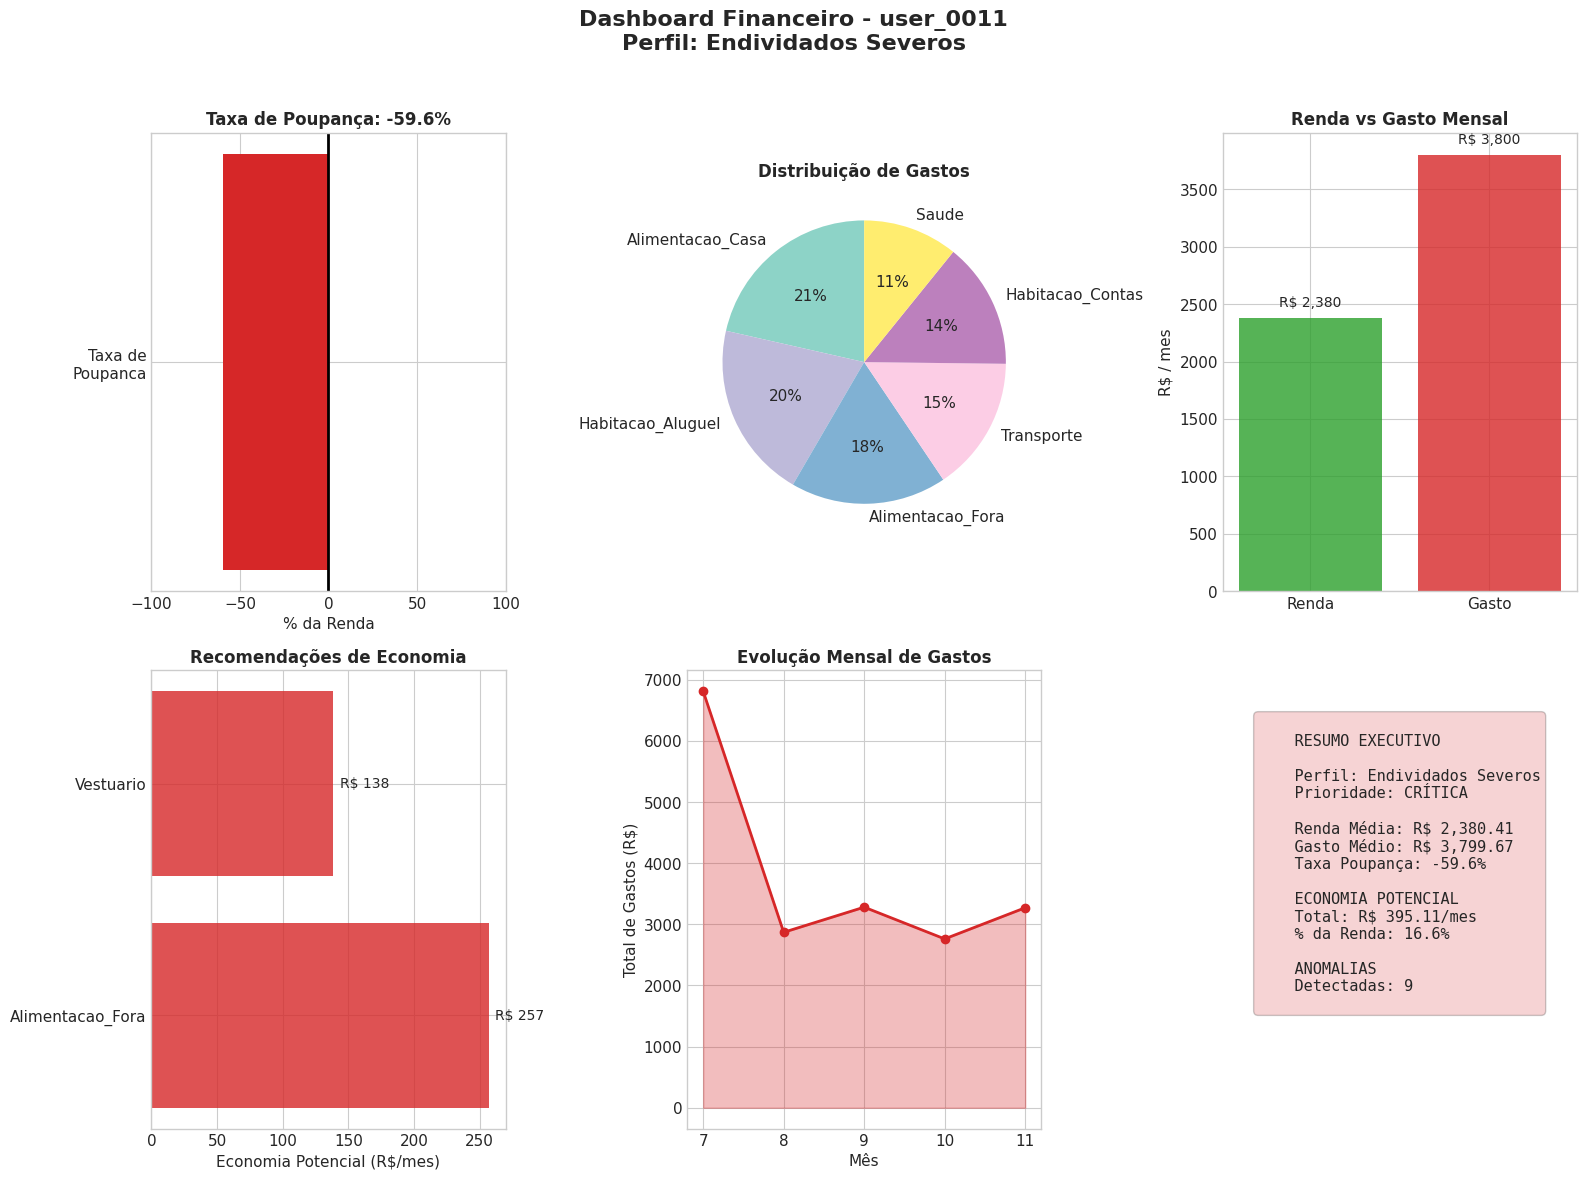

In [8]:
criar_dashboard_usuario(resultado_0, transacoes, '../outputs/demo_cluster_0.png')

---
## 6. Demonstração: Cluster 1 - Em Alerta

In [9]:
# Analisar usuário do Cluster 1
user_cluster_1 = usuarios_demo[1]
resultado_1 = pipeline.analisar_usuario(user_cluster_1, transacoes)

exibir_perfil_usuario(resultado_1)
exibir_recomendacoes(resultado_1)
exibir_anomalias(resultado_1)


  PERFIL DO USUÁRIO: user_0004

>>> CLASSIFICAÇÃO
    Perfil: Em Alerta
    Prioridade de ação: MODERADA
    Confiança: 51.3%

>>> SITUAÇÃO FINANCEIRA
    Renda média mensal: R$ 3,332.65
    Gasto médio mensal: R$ 3,815.74
    Taxa de poupança: -14.5% (NEGATIVA - gastando mais que ganha)
    Gastos essenciais: 79.9% do total

>>> RECOMENDAÇÕES PERSONALIZADAS
    Economia potencial total: R$ 168.18/mês
    Equivale a 5.0% da renda

    [1] Reduzir refeições fora de casa
        Categoria: Alimentacao_Fora
        Gasto atual: R$ 342.10/mês
        Redução sugerida: 40%
        Economia: R$ 136.84/mês
        Dica: Leve marmita para o trabalho pelo menos 3x por semana

    [2] Estabelecer teto para lazer
        Categoria: Lazer
        Gasto atual: R$ 89.54/mês
        Redução sugerida: 35%
        Economia: R$ 31.34/mês
        Dica: Busque alternativas gratuitas: parques, eventos culturais, bibliotecas

>>> ALERTAS DE TRANSAÇÕES ATÍPICAS
    Total detectadas: 11 de 381 transações
   

Dashboard salvo: ../outputs/demo_cluster_1.png


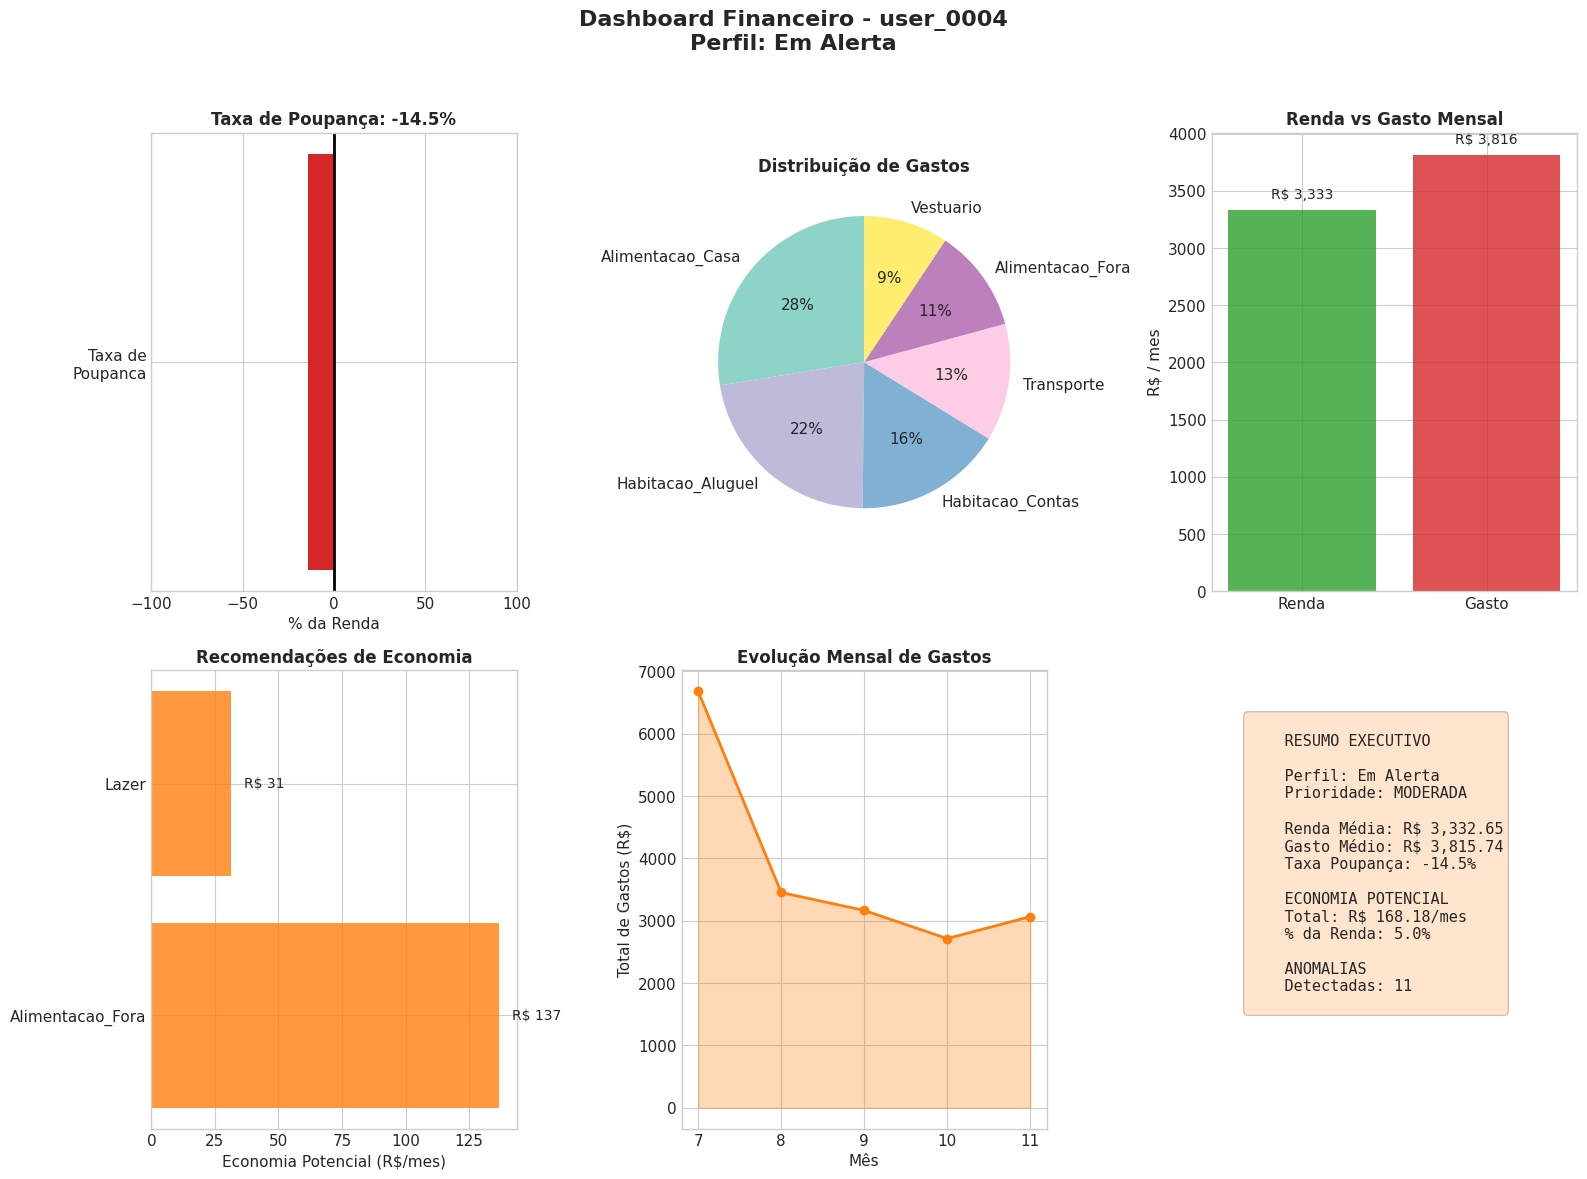

In [10]:
criar_dashboard_usuario(resultado_1, transacoes, '../outputs/demo_cluster_1.png')

---
## 7. Demonstração: Cluster 2 - Endividados Moderados

In [11]:
# Analisar usuário do Cluster 2
user_cluster_2 = usuarios_demo[2]
resultado_2 = pipeline.analisar_usuario(user_cluster_2, transacoes)

exibir_perfil_usuario(resultado_2)
exibir_recomendacoes(resultado_2)
exibir_anomalias(resultado_2)


  PERFIL DO USUÁRIO: user_0002

>>> CLASSIFICAÇÃO
    Perfil: Endividados Moderados
    Prioridade de ação: ALTA
    Confiança: 46.5%

>>> SITUAÇÃO FINANCEIRA
    Renda média mensal: R$ 4,148.90
    Gasto médio mensal: R$ 7,084.61
    Taxa de poupança: -70.8% (NEGATIVA - gastando mais que ganha)
    Gastos essenciais: 80.1% do total

>>> RECOMENDAÇÕES PERSONALIZADAS
    Economia potencial total: R$ 842.26/mês
    Equivale a 20.3% da renda

    [1] Cortar refeições fora de casa
        Categoria: Alimentacao_Fora
        Gasto atual: R$ 737.54/mês
        Redução sugerida: 70%
        Economia: R$ 516.28/mês
        Dica: Planeje cardápio semanal e faça compras com lista

    [2] Suspender compras de vestuário
        Categoria: Vestuario
        Gasto atual: R$ 362.20/mês
        Redução sugerida: 90%
        Economia: R$ 325.98/mês
        Dica: Revise o guarda-roupa e conserte peças antes de comprar novas

>>> ALERTAS DE TRANSAÇÕES ATÍPICAS
    Total detectadas: 28 de 398 transações

Dashboard salvo: ../outputs/demo_cluster_2.png


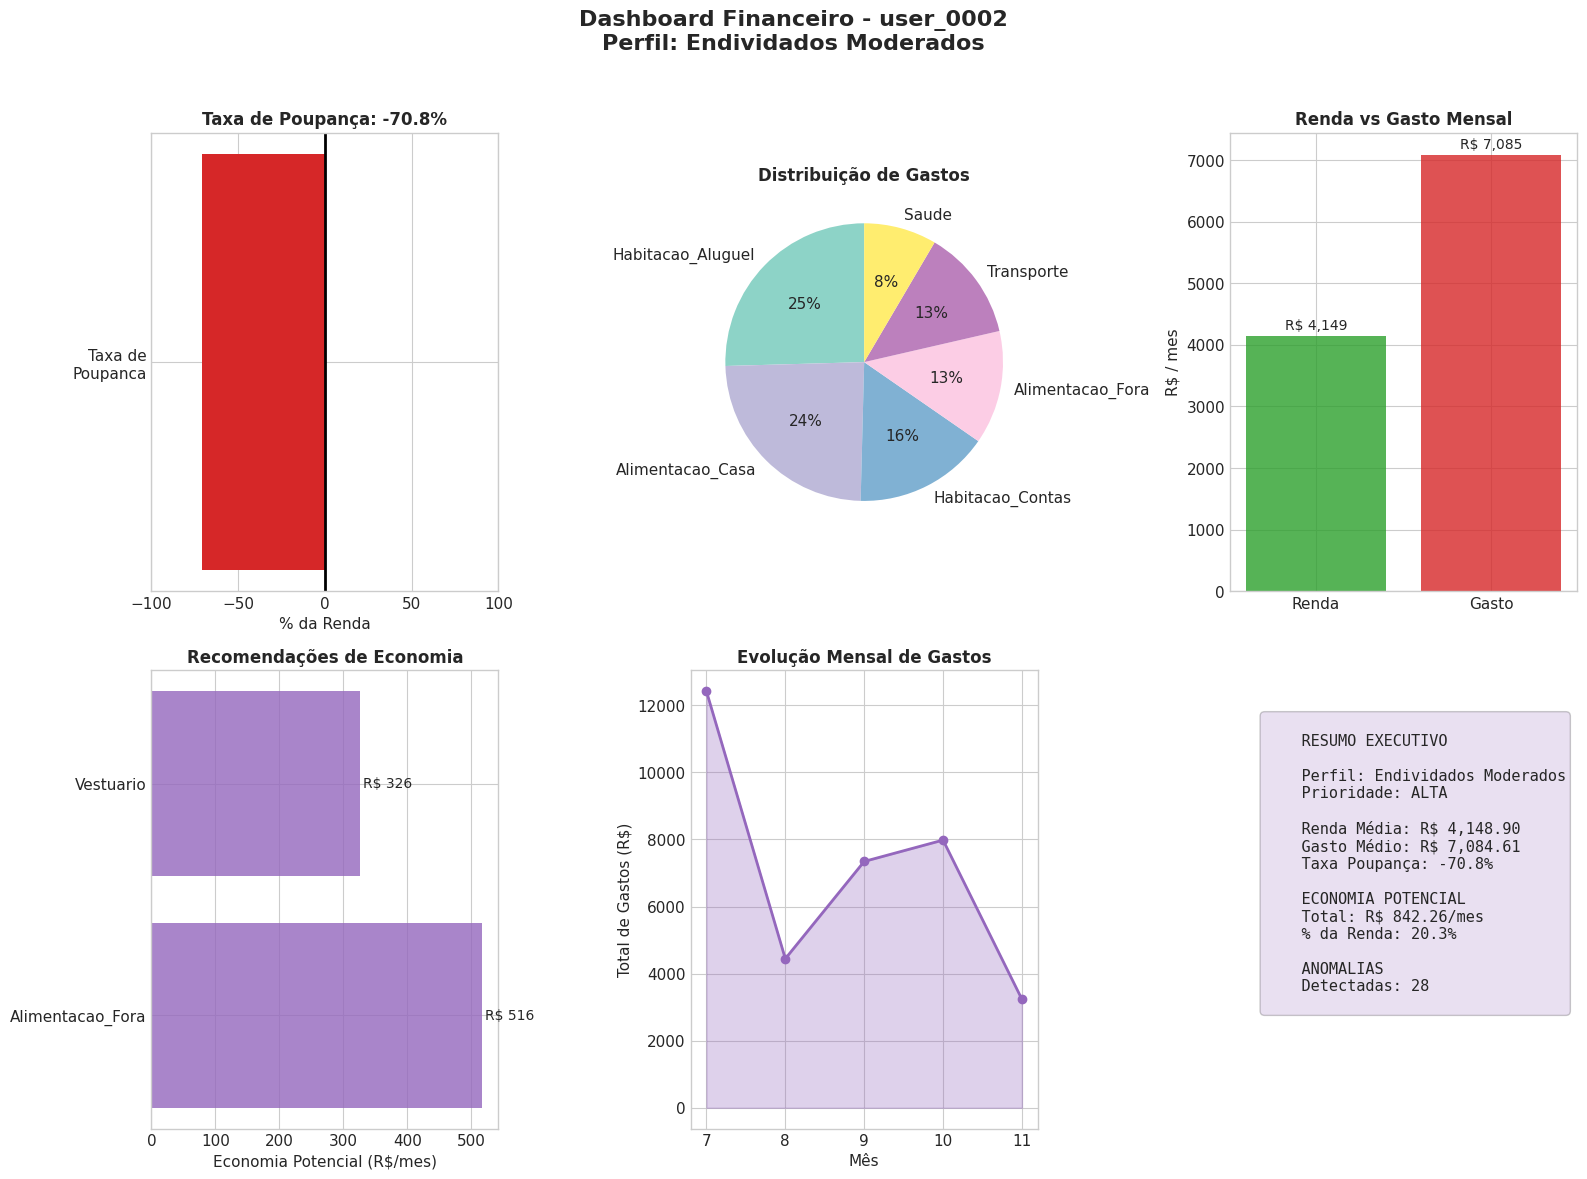

In [12]:
criar_dashboard_usuario(resultado_2, transacoes, '../outputs/demo_cluster_2.png')

---
## 8. Demonstração: Cluster 3 - Poupadores

In [13]:
# Analisar usuário do Cluster 3
user_cluster_3 = usuarios_demo[3]
resultado_3 = pipeline.analisar_usuario(user_cluster_3, transacoes)

exibir_perfil_usuario(resultado_3)
exibir_recomendacoes(resultado_3)
exibir_anomalias(resultado_3)


  PERFIL DO USUÁRIO: user_0001

>>> CLASSIFICAÇÃO
    Perfil: Poupadores
    Prioridade de ação: BAIXA
    Confiança: 23.5%

>>> SITUAÇÃO FINANCEIRA
    Renda média mensal: R$ 12,252.48
    Gasto médio mensal: R$ 3,834.97
    Taxa de poupança: +68.7% (positiva)
    Gastos essenciais: 79.8% do total

>>> RECOMENDAÇÕES PERSONALIZADAS
    Economia potencial total: R$ 93.57/mês
    Equivale a 0.8% da renda

    [1] Otimizar gastos com transporte
        Categoria: Transporte
        Gasto atual: R$ 486.08/mês
        Redução sugerida: 15%
        Economia: R$ 72.91/mês
        Dica: Considere caronas, transporte público ou bicicleta para trajetos curtos

    [2] Revisar planos e assinaturas
        Categoria: Telecomunicacoes
        Gasto atual: R$ 103.30/mês
        Redução sugerida: 20%
        Economia: R$ 20.66/mês
        Dica: Cancele assinaturas não utilizadas e negocie valores com operadoras

>>> ALERTAS DE TRANSAÇÕES ATÍPICAS
    Total detectadas: 14 de 392 transações
    Percen

Dashboard salvo: ../outputs/demo_cluster_3.png


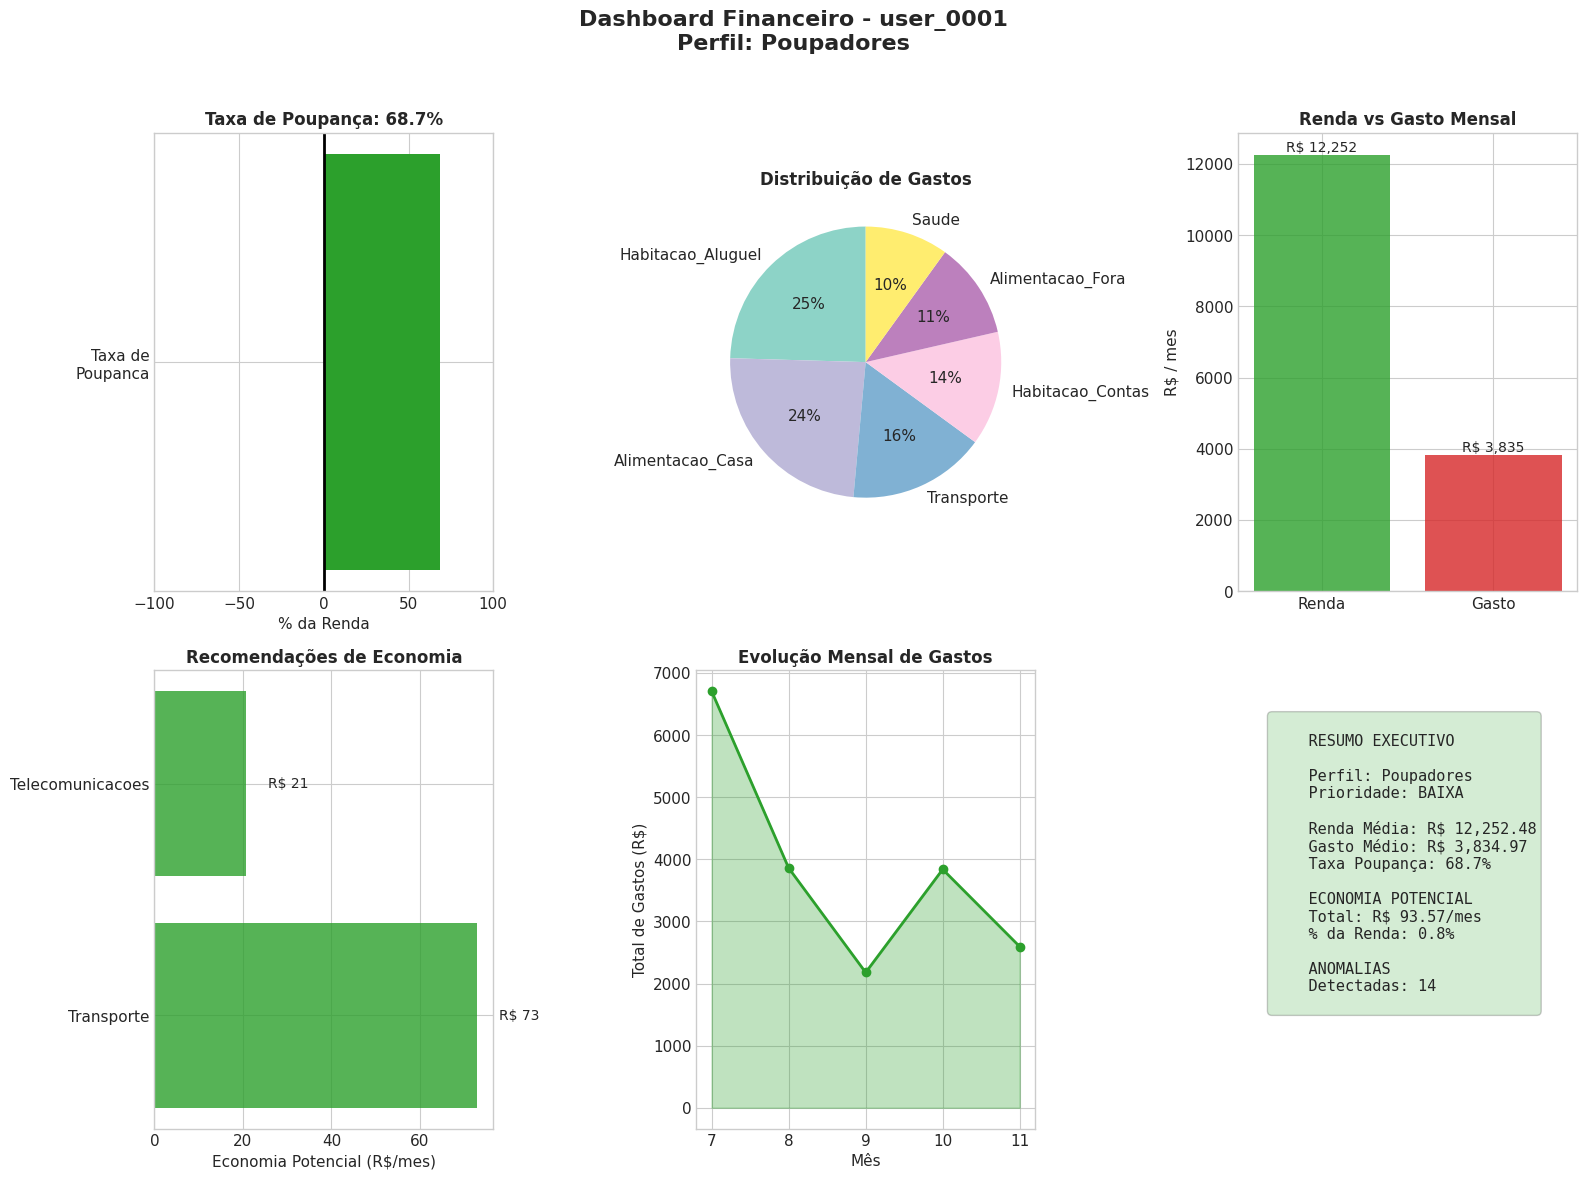

In [14]:
criar_dashboard_usuario(resultado_3, transacoes, '../outputs/demo_cluster_3.png')

---
## 9. Comparativo entre Perfis

In [15]:
# Criar comparativo visual
print("\n" + "="*70)
print("COMPARATIVO ENTRE PERFIS")
print("="*70)

resultados = [resultado_0, resultado_1, resultado_2, resultado_3]

comparativo = []
for r in resultados:
    comparativo.append({
        'Perfil': r['perfil']['cluster_nome'],
        'Usuario': r['user_id'],
        'Renda (R$)': r['financeiro']['renda_media'],
        'Gasto (R$)': r['financeiro']['gasto_medio'],
        'Taxa Poup. (%)': r['financeiro']['taxa_poupanca'],
        'Economia (R$)': r['economia']['total_mensal'],
        'Anomalias': r['anomalias']['total_anomalias']
    })

df_comparativo = pd.DataFrame(comparativo)
print("\n")
print(df_comparativo.to_string(index=False))


COMPARATIVO ENTRE PERFIS


               Perfil   Usuario  Renda (R$)  Gasto (R$)  Taxa Poup. (%)  Economia (R$)  Anomalias
  Endividados Severos user_0011     2380.41     3799.67          -59.62         395.11          9
            Em Alerta user_0004     3332.65     3815.74          -14.50         168.18         11
Endividados Moderados user_0002     4148.90     7084.61          -70.76         842.26         28
           Poupadores user_0001    12252.48     3834.97           68.70          93.57         14


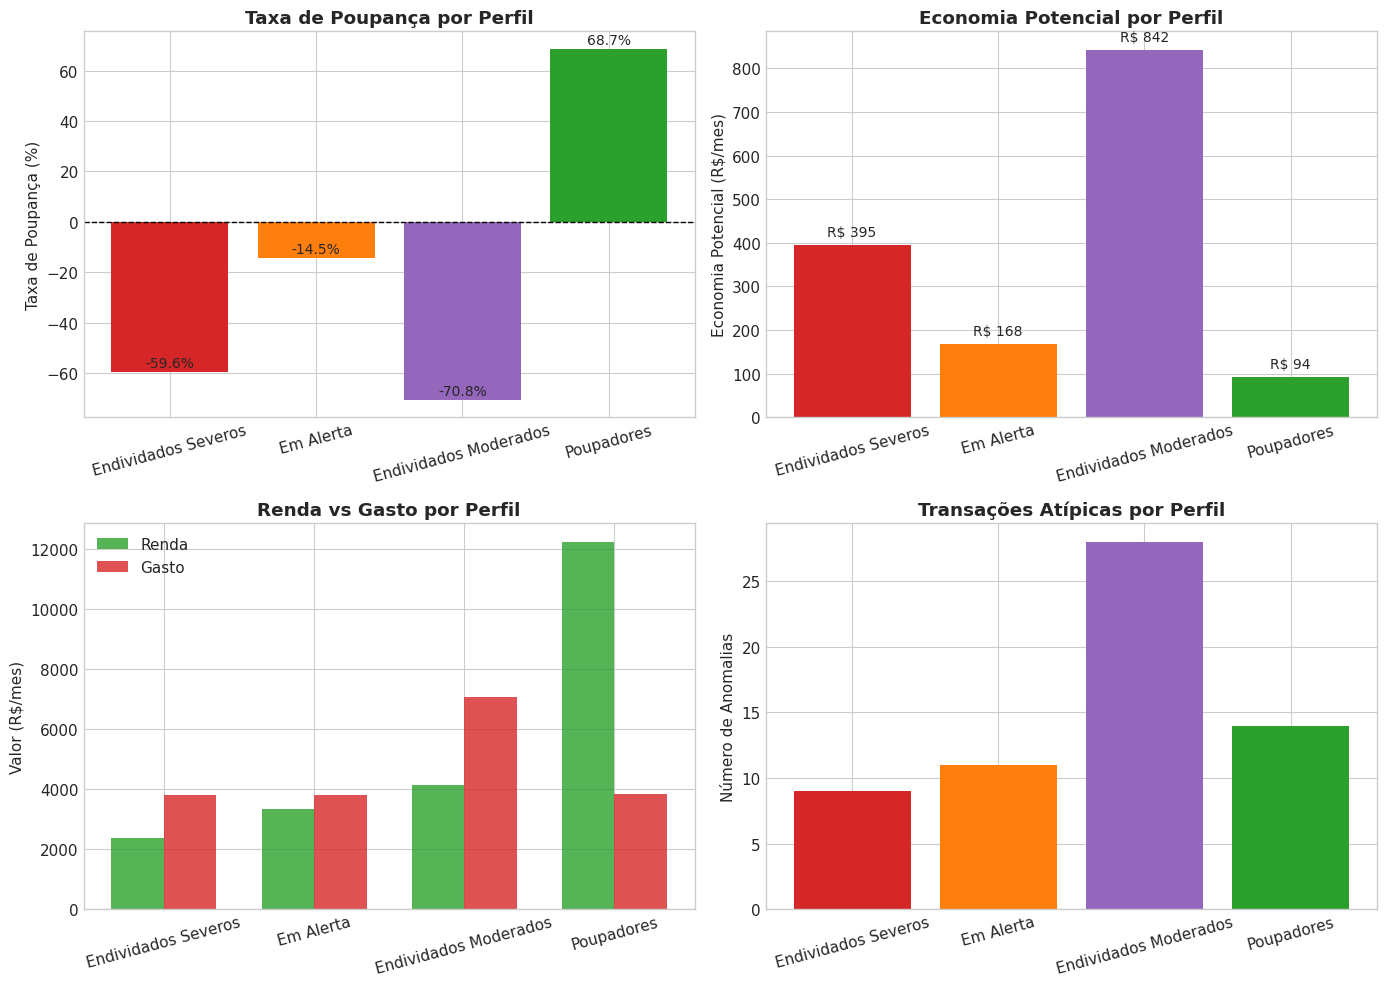


Gráfico salvo: outputs/demo_comparativo_perfis.png


In [16]:
# Grafico comparativo
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

perfis = [r['perfil']['cluster_nome'] for r in resultados]
cores = [CORES_CLUSTER[r['perfil']['cluster']] for r in resultados]

# 1. Taxa de poupança por perfil
taxas = [r['financeiro']['taxa_poupanca'] for r in resultados]
bars1 = axes[0, 0].bar(perfis, taxas, color=cores)
axes[0, 0].axhline(y=0, color='black', linewidth=1, linestyle='--')
axes[0, 0].set_ylabel('Taxa de Poupança (%)')
axes[0, 0].set_title('Taxa de Poupança por Perfil', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=15)
for bar, val in zip(bars1, taxas):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                   f'{val:.1f}%', ha='center', fontsize=10)

# 2. Economia potencial por perfil
economias = [r['economia']['total_mensal'] for r in resultados]
bars2 = axes[0, 1].bar(perfis, economias, color=cores)
axes[0, 1].set_ylabel('Economia Potencial (R$/mes)')
axes[0, 1].set_title('Economia Potencial por Perfil', fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=15)
for bar, val in zip(bars2, economias):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
                   f'R$ {val:,.0f}', ha='center', fontsize=10)

# 3. Renda vs Gasto por perfil
x = np.arange(len(perfis))
width = 0.35
rendas = [r['financeiro']['renda_media'] for r in resultados]
gastos = [r['financeiro']['gasto_medio'] for r in resultados]

axes[1, 0].bar(x - width/2, rendas, width, label='Renda', color='#2ca02c', alpha=0.8)
axes[1, 0].bar(x + width/2, gastos, width, label='Gasto', color='#d62728', alpha=0.8)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(perfis, rotation=15)
axes[1, 0].set_ylabel('Valor (R$/mes)')
axes[1, 0].set_title('Renda vs Gasto por Perfil', fontweight='bold')
axes[1, 0].legend()

# 4. Anomalias detectadas por perfil
anomalias = [r['anomalias']['total_anomalias'] for r in resultados]
bars4 = axes[1, 1].bar(perfis, anomalias, color=cores)
axes[1, 1].set_ylabel('Número de Anomalias')
axes[1, 1].set_title('Transações Atípicas por Perfil', fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('../outputs/demo_comparativo_perfis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("\nGráfico salvo: outputs/demo_comparativo_perfis.png")

---
## 10. Validação de Reproducibilidade

In [17]:
print("\n" + "="*70)
print("VALIDAÇÃO DE REPRODUCIBILIDADE")
print("="*70)

# Testar reproducibilidade: mesma entrada deve gerar mesma saída
print("\nTestando reproducibilidade do pipeline...")

# Executar análise 3 vezes para o mesmo usuário
user_teste = 'user_0001'
resultados_reproducibilidade = []

for i in range(3):
    resultado = pipeline.analisar_usuario(user_teste, transacoes)
    resultados_reproducibilidade.append({
        'execução': i + 1,
        'cluster': resultado['perfil']['cluster'],
        'taxa_poupanca': resultado['financeiro']['taxa_poupanca'],
        'economia': resultado['economia']['total_mensal'],
        'anomalias': resultado['anomalias']['total_anomalias']
    })

df_repro = pd.DataFrame(resultados_reproducibilidade)
print(f"\nResultados para {user_teste} em 3 execuções:")
print(df_repro.to_string(index=False))

# Verificar se todos os resultados são iguais
reproducivel = (df_repro['cluster'].nunique() == 1 and 
                df_repro['taxa_poupanca'].nunique() == 1 and
                df_repro['economia'].nunique() == 1)

print(f"\n>>> Pipeline REPRODUCÍVEL: {'SIM' if reproducivel else 'NÃO'}")


VALIDAÇÃO DE REPRODUCIBILIDADE

Testando reproducibilidade do pipeline...

Resultados para user_0001 em 3 execuções:
 execução  cluster  taxa_poupanca  economia  anomalias
        1        3           68.7     93.57         14
        2        3           68.7     93.57         14
        3        3           68.7     93.57         14

>>> Pipeline REPRODUCÍVEL: SIM


In [18]:
# Teste de carga: analisar múltiplos usuários
print("\nTeste de carga: analisando 50 usuários...")

import time

usuarios_teste = usuarios_clustered['user_id'].head(50).tolist()

inicio = time.time()
resultados_carga = []
for user_id in usuarios_teste:
    resultado = pipeline.analisar_usuario(user_id, transacoes)
    resultados_carga.append(resultado)
fim = time.time()

tempo_total = fim - inicio
tempo_medio = tempo_total / len(usuarios_teste)

print(f"\nResultados do teste de carga:")
print(f"  Usuários analisados: {len(usuarios_teste)}")
print(f"  Tempo total: {tempo_total:.2f} segundos")
print(f"  Tempo médio por usuário: {tempo_medio:.3f} segundos")
print(f"  Throughput: {len(usuarios_teste)/tempo_total:.1f} usuários/segundo")


Teste de carga: analisando 50 usuários...

Resultados do teste de carga:
  Usuários analisados: 50
  Tempo total: 1.48 segundos
  Tempo médio por usuário: 0.030 segundos
  Throughput: 33.7 usuários/segundo


---
## 11. Resumo da Demonstração

In [19]:
print("\n" + "="*70)
print("RESUMO DA DEMONSTRAÇÃO - ECONOMIZA+ MVP")
print("="*70)

print("""
SISTEMA DEMONSTRADO COM SUCESSO!

COMPONENTES VALIDADOS:
  [x] Classificação de perfil (K-means, 4 clusters)
  [x] Sistema de recomendações (8 regras, 2 por cluster)
  [x] Detecção de anomalias (Isolation Forest)
  [x] Pipeline integrado (função analisar_usuario)

PERFIS DEMONSTRADOS:
  [x] Cluster 0 - Endividados Severos (prioridade CRÍTICA)
  [x] Cluster 1 - Em Alerta (prioridade MODERADA)
  [x] Cluster 2 - Endividados Moderados (prioridade ALTA)
  [x] Cluster 3 - Poupadores (prioridade BAIXA)

FUNCIONALIDADES:
  - Entrada: ID do usuário
  - Saída: Perfil completo com:
    * Classificação e prioridade
    * Situação financeira detalhada
    * 2 recomendações personalizadas
    * Economia potencial calculada
    * Alertas de transações atípicas

ARTEFATOS GERADOS:
  - outputs/demo_cluster_0.png
  - outputs/demo_cluster_1.png
  - outputs/demo_cluster_2.png
  - outputs/demo_cluster_3.png
  - outputs/demo_comparativo_perfis.png
""")

print(f"\nData da demonstração: {datetime.now().strftime('%d/%m/%Y %H:%M')}")


RESUMO DA DEMONSTRAÇÃO - ECONOMIZA+ MVP

SISTEMA DEMONSTRADO COM SUCESSO!

COMPONENTES VALIDADOS:
  [x] Classificação de perfil (K-means, 4 clusters)
  [x] Sistema de recomendações (8 regras, 2 por cluster)
  [x] Detecção de anomalias (Isolation Forest)
  [x] Pipeline integrado (função analisar_usuario)

PERFIS DEMONSTRADOS:
  [x] Cluster 0 - Endividados Severos (prioridade CRÍTICA)
  [x] Cluster 1 - Em Alerta (prioridade MODERADA)
  [x] Cluster 2 - Endividados Moderados (prioridade ALTA)
  [x] Cluster 3 - Poupadores (prioridade BAIXA)

FUNCIONALIDADES:
  - Entrada: ID do usuário
  - Saída: Perfil completo com:
    * Classificação e prioridade
    * Situação financeira detalhada
    * 2 recomendações personalizadas
    * Economia potencial calculada
    * Alertas de transações atípicas

ARTEFATOS GERADOS:
  - outputs/demo_cluster_0.png
  - outputs/demo_cluster_1.png
  - outputs/demo_cluster_2.png
  - outputs/demo_cluster_3.png
  - outputs/demo_comparativo_perfis.png


Data da demonstr

---
## 12. Checklist Dia 13

In [20]:
print("\n" + "="*70)
print("CHECKLIST DIA 13")
print("="*70)
print("\n[x] Carregar pipeline completo")
print("[x] Selecionar usuários representativos de cada cluster")
print("[x] Criar funções de exibição (perfil, recomendações, anomalias)")
print("[x] Criar função de dashboard visual")
print("[x] Demonstrar Cluster 0 - Endividados Severos")
print("[x] Demonstrar Cluster 1 - Em Alerta")
print("[x] Demonstrar Cluster 2 - Endividados Moderados")
print("[x] Demonstrar Cluster 3 - Poupadores")
print("[x] Criar gráfico comparativo entre perfis")
print("[x] Validar reproducibilidade (3 execuções idênticas)")
print("[x] Teste de carga (50 usuários)")
print("[x] Salvar todos os dashboards em outputs/")
print("\n>>> DIA 13 CONCLUÍDO!")
print("\nPróximo passo (Dia 14): Documentação e Review Final")


CHECKLIST DIA 13

[x] Carregar pipeline completo
[x] Selecionar usuários representativos de cada cluster
[x] Criar funções de exibição (perfil, recomendações, anomalias)
[x] Criar função de dashboard visual
[x] Demonstrar Cluster 0 - Endividados Severos
[x] Demonstrar Cluster 1 - Em Alerta
[x] Demonstrar Cluster 2 - Endividados Moderados
[x] Demonstrar Cluster 3 - Poupadores
[x] Criar gráfico comparativo entre perfis
[x] Validar reproducibilidade (3 execuções idênticas)
[x] Teste de carga (50 usuários)
[x] Salvar todos os dashboards em outputs/

>>> DIA 13 CONCLUÍDO!

Próximo passo (Dia 14): Documentação e Review Final
